In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingRegressor

In [2]:
# df = pd.read_csv("ghg-emissions-by-gas.csv").rename(
# 	columns={
# 		"Annual nitrous oxide emissions in CO₂ equivalents": "N2O",
# 		"Annual methane emissions in CO₂ equivalents": "CH4",
# 		"Annual CO₂ emissions": "CO2",
# 	}
# )
# df

In [3]:
df = pd.read_csv(
	"https://ourworldindata.org/grapher/ghg-emissions-by-gas.csv?v=1&csvType=full&useColumnShortNames=true", 
	storage_options = {
		"User-Agent": "Our World In Data data fetch/1.0"
	}
).rename(
	columns={
		"annual_emissions_n2o_total_co2eq": "N2O",
		"annual_emissions_ch4_total_co2eq": "CH4",
		"annual_emissions_co2_total": "CO2",
	}
)

df

,Entity,Code,Year,N2O,CH4,CO2
0,Afghanistan,AFG,1850,224421.52,3594926.2,3616395.5
1,Afghanistan,AFG,1851,229096.17,3615134.2,3655627.8
2,Afghanistan,AFG,1852,233650.48,3635346.8,3691498.5
3,Afghanistan,AFG,1853,238009.98,3655563.5,3726324.5
4,Afghanistan,AFG,1854,242100.23,3675785.0,3760235.0
...,...,...,...,...,...,...
41233,Zimbabwe,ZWE,2019,5095680.00,12956743.0,16295433.0
41234,Zimbabwe,ZWE,2020,4574374.00,12643310.0,14105223.0
41235,Zimbabwe,ZWE,2021,4857981.00,13046190.0,15645219.0
41236,Zimbabwe,ZWE,2022,4855070.00,12946108.0,15971238.0


In [4]:
sum_year = df.groupby("Year", dropna=True)[["N2O", "CH4", "CO2"]].sum()
sum_year

,N2O,CH4,CO2
Year,,,
1850,7.659910e+08,6.487649e+09,1.514331e+10
1851,7.797316e+08,6.512152e+09,1.613188e+10
1852,7.931728e+08,6.550685e+09,1.639097e+10
1853,8.061293e+08,6.594735e+09,1.663857e+10
1854,8.184158e+08,6.673776e+09,1.700238e+10
...,...,...,...
2019,1.423219e+10,4.958402e+10,1.938141e+11
2020,1.441520e+10,4.896311e+10,1.834298e+11
2021,1.460704e+10,4.973363e+10,1.926551e+11


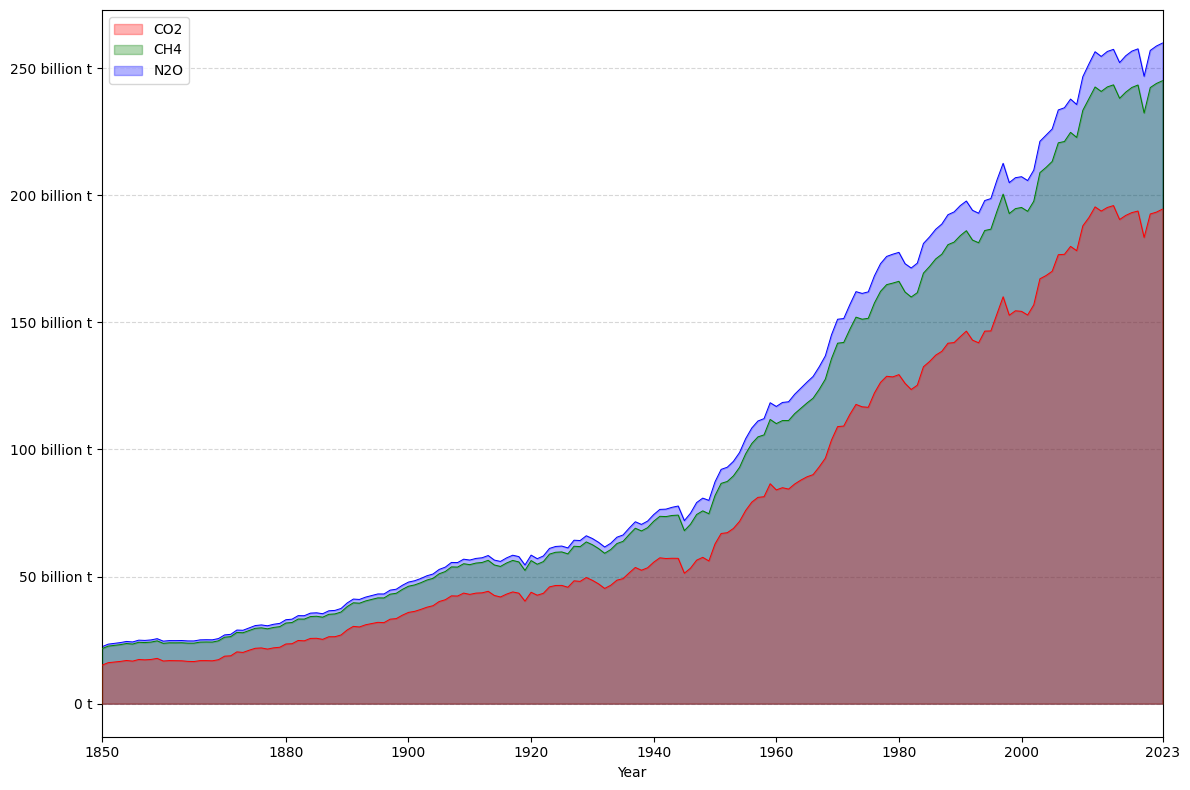

In [5]:
plt.figure(figsize=(12, 8))

plt.fill_between(sum_year.index, 0, sum_year["CO2"], alpha=.3, color="red", label="CO2", zorder=4)
plt.fill_between(sum_year.index, 0, sum_year["CH4"] + sum_year["CO2"], alpha=.3, color="green", label="CH4", zorder=3)
plt.fill_between(sum_year.index, 0, sum_year["N2O"] + sum_year["CH4"] + sum_year["CO2"], alpha=.3, color="blue", label="N2O", zorder=2)

plt.plot(sum_year.index, sum_year["CO2"], lw=.7, color="red", zorder=4)
plt.plot(sum_year.index, sum_year["CH4"] + sum_year["CO2"], lw=.7, color="green", zorder=3)
plt.plot(sum_year.index, sum_year["N2O"] + sum_year["CH4"] + sum_year["CO2"], lw=.7, color="blue", zorder=2)

plt.xlabel("Year")
plt.xticks([1850] + [sum_year.index[i] for i in range(30, len(sum_year.index) - 20, 20)] + [2023])
plt.yticks(
	[i for i in range(0, 300_000_000_000, 50_000_000_000)],
	[f"{i} billion t" if i != 0 else "0 t" for i in range(0, 300, 50)]
)

plt.grid(axis="y", alpha=.5, ls="--")
plt.legend()

plt.margins(x=0)

plt.tight_layout()
plt.show()

In [6]:
x = df[df["Year"] <= 1980].groupby("Year", dropna=True)[["N2O", "CH4", "CO2"]].sum()
y = df[df["Year"] >= 1980].groupby("Year", dropna=True)[["N2O", "CH4", "CO2"]].sum()

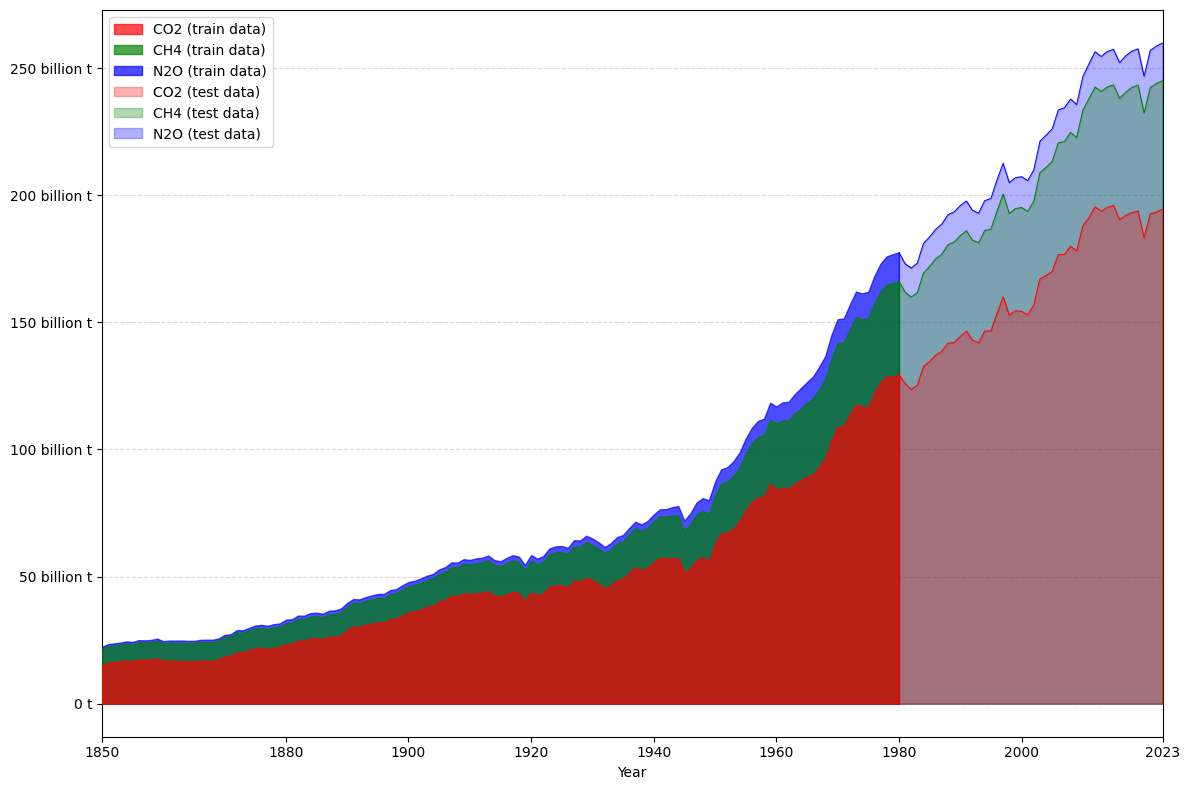

In [7]:
plt.figure(figsize=(12, 8))

plt.fill_between(x.index, 0, x["CO2"], alpha=.7, color="red", label="CO2 (train data)", zorder=4)
plt.fill_between(x.index, 0, x["CH4"] + x["CO2"], alpha=.7, color="green", label="CH4 (train data)", zorder=3)
plt.fill_between(x.index, 0, x["N2O"] + x["CH4"] + x["CO2"], alpha=.7, color="blue", label="N2O (train data)", zorder=2)


plt.fill_between(y.index, 0, y["CO2"], alpha=.3, color="red", label="CO2 (test data)", zorder=4)
plt.fill_between(y.index, 0, y["CH4"] + y["CO2"], alpha=.3, color="green", label="CH4 (test data)", zorder=3)
plt.fill_between(y.index, 0, y["N2O"] + y["CH4"] + y["CO2"], alpha=.3, color="blue", label="N2O (test data)", zorder=2)

# plt.plot(x.index, x["CO2"], lw=.7, color="red", zorder=4)
# plt.plot(x.index, x["CH4"] + x["CO2"], lw=.7, color="green", zorder=3)
# plt.plot(x.index, x["N2O"] + x["CH4"] + x["CO2"], lw=.7, color="blue", zorder=2)

plt.plot(y.index, y["CO2"], lw=.7, color="red", zorder=4)
plt.plot(y.index, y["CH4"] + y["CO2"], lw=.7, color="green", zorder=3)
plt.plot(y.index, y["N2O"] + y["CH4"] + y["CO2"], lw=.7, color="blue", zorder=2)


plt.xlabel("Year")
plt.xticks([1850] + [sum_year.index[i] for i in range(30, len(sum_year.index) - 20, 20)] + [2023])
plt.yticks(
	[i for i in range(0, 300_000_000_000, 50_000_000_000)],
	[f"{i} billion t" if i != 0 else "0 t" for i in range(0, 300, 50)]
)

plt.grid(axis="y", alpha=.5, ls="--")
plt.legend()

plt.margins(x=0)

plt.tight_layout()
plt.show()

In [8]:
x_data, y_data = x.sum(1), y.sum(1)

x_train, x_test = x_data.index.to_frame(), y_data.index.to_frame()
y_train, y_test = x_data.values, y_data.values
	
model = LinearRegression().fit(x_train, np.log(y_train))
pred_train = np.exp(model.predict(x_train))
pred_test = np.exp(model.predict(x_test))

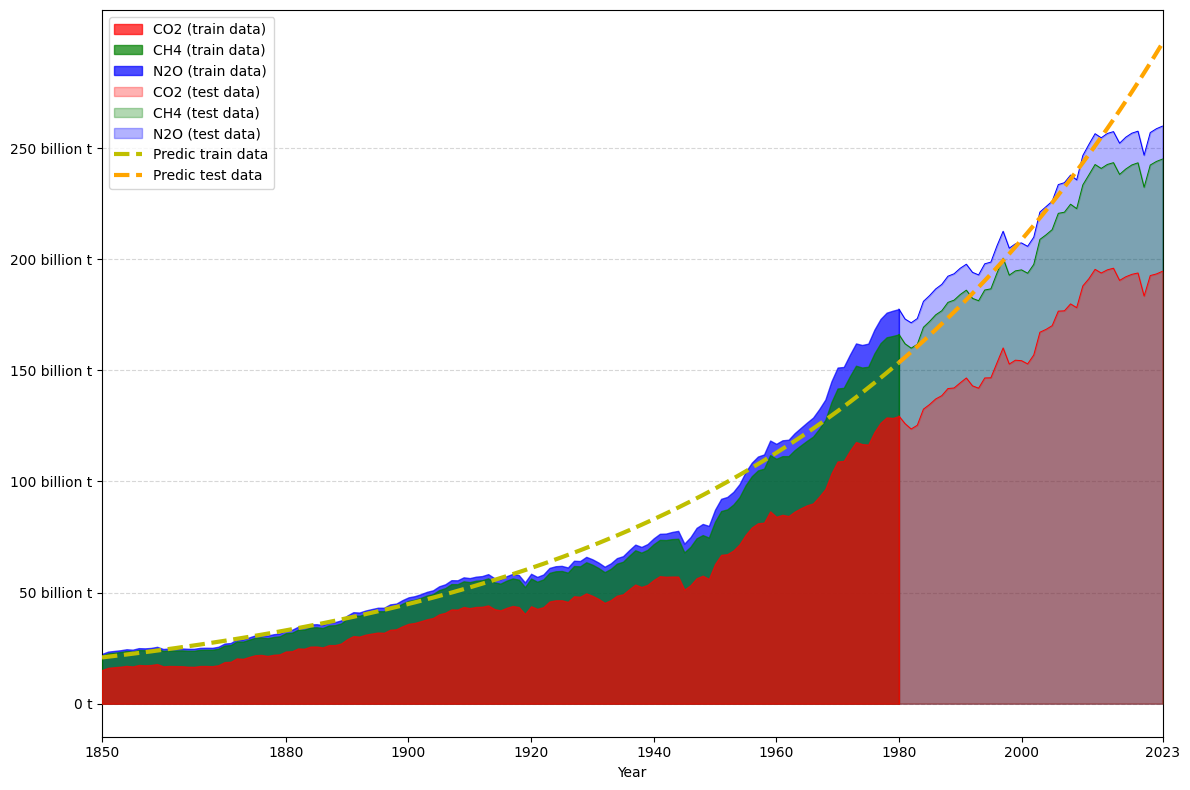

In [9]:
plt.figure(figsize=(12, 8))

plt.fill_between(x.index, 0, x["CO2"], alpha=.7, color="red", label="CO2 (train data)", zorder=4)
plt.fill_between(x.index, 0, x["CH4"] + x["CO2"], alpha=.7, color="green", label="CH4 (train data)", zorder=3)
plt.fill_between(x.index, 0, x["N2O"] + x["CH4"] + x["CO2"], alpha=.7, color="blue", label="N2O (train data)", zorder=2)


plt.fill_between(y.index, 0, y["CO2"], alpha=.3, color="red", label="CO2 (test data)", zorder=4)
plt.fill_between(y.index, 0, y["CH4"] + y["CO2"], alpha=.3, color="green", label="CH4 (test data)", zorder=3)
plt.fill_between(y.index, 0, y["N2O"] + y["CH4"] + y["CO2"], alpha=.3, color="blue", label="N2O (test data)", zorder=2)

# plt.plot(x.index, x["CO2"], lw=.7, color="red", zorder=4)
# plt.plot(x.index, x["CH4"] + x["CO2"], lw=.7, color="green", zorder=3)
# plt.plot(x.index, x["N2O"] + x["CH4"] + x["CO2"], lw=.7, color="blue", zorder=2)

plt.plot(y.index, y["CO2"], lw=.7, color="red", zorder=4)
plt.plot(y.index, y["CH4"] + y["CO2"], lw=.7, color="green", zorder=3)
plt.plot(y.index, y["N2O"] + y["CH4"] + y["CO2"], lw=.7, color="blue", zorder=2)


plt.plot(x.index, pred_train, label="Predic train data", zorder=6, ls="--", lw=3, c="y")
plt.plot(y.index, pred_test, label="Predic test data", zorder=6, ls="--", lw=3, c="orange")


plt.xlabel("Year")
plt.xticks([1850] + [sum_year.index[i] for i in range(30, len(sum_year.index) - 20, 20)] + [2023])
plt.yticks(
	[i for i in range(0, 300_000_000_000, 50_000_000_000)],
	[f"{i} billion t" if i != 0 else "0 t" for i in range(0, 300, 50)]
)

plt.grid(axis="y", alpha=.5, ls="--")
plt.legend()

plt.margins(x=0)

plt.tight_layout()
plt.show()